# Neural Bandit

Implementing neural bandit using scikit-learn's multilayer perceptron.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
USER_LIKED_ARTICLE = 1.0
USER_DISLIKED_ARTICLE = 0.0

In [3]:
def get_cost(context, action):
    match (context["user"], context["time_of_day"], action):
        case ("Tom", "morning", "politics"):
            return USER_LIKED_ARTICLE
        case ("Tom", "afternoon", "music"):
            return USER_LIKED_ARTICLE
        case ("Anna", "morning", "sports"):
            return USER_LIKED_ARTICLE
        case ("Anna", "afternoon", "politics"):
            return USER_LIKED_ARTICLE
        case _:
            return USER_DISLIKED_ARTICLE

In [4]:
users = ["Tom", "Anna"]
times_of_day = ["morning", "afternoon"]
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]


def one_hot_encode(user, time_of_day, action):
    return [users.index(user) + 1, times_of_day.index(time_of_day) + 1] + [
        1 if a == action else 0 for a in actions
    ]


one_hot_encode("Tom", "morning", "politics")

[1, 1, 1, 0, 0, 0, 0, 0, 0]

In [5]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if sum_prob > draw:
            return index, prob

In [6]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(activation="relu", random_state=42)
model.partial_fit([one_hot_encode("Tom", "morning", "politics")], [1])
model.predict([one_hot_encode("Tom", "morning", "politics")])

array([0.20727216])

In [7]:
# Sampling best reward for the action taken.
pmf = model.predict([one_hot_encode("Tom", "morning", action) for action in actions])
action, prob = sample_custom_pmf(pmf)
pmf, action, prob

(array([ 0.20727216,  0.11697445,  0.33291172,  0.24473987,  0.35555384,
         0.13795523, -0.00638099]),
 2,
 0.23967272934346098)

In [8]:
def choose_user(users):
    return random.choice(users)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)


def get_action(model, context, actions):
    pmf = model.predict(
        [
            one_hot_encode(context["user"], context["time_of_day"], action)
            for action in actions
        ]
    )
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [9]:
def run_simulation(
    model,
    num_iterations,
    users,
    times_of_day,
    actions,
    cost_function,
    do_learn=True,
    do_punish=True,
):
    cost_sum = 0.0
    ctr = []

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {"user": user, "time_of_day": time_of_day}
        action, prob = get_action(model, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Learn
            model.partial_fit([one_hot_encode(user, time_of_day, action)], [cost])
        elif do_punish:
            # Reward the positive actions, but also punish the negative ones.
            X_train = [one_hot_encode(user, time_of_day, action) for action in actions]
            y_train = [cost if action == a else 0 for a in actions]
            model.partial_fit(X_train, y_train)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(1 * cost_sum / i)

    return ctr

In [10]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("ctr", fontsize=14)
    plt.ylim([0, 1])

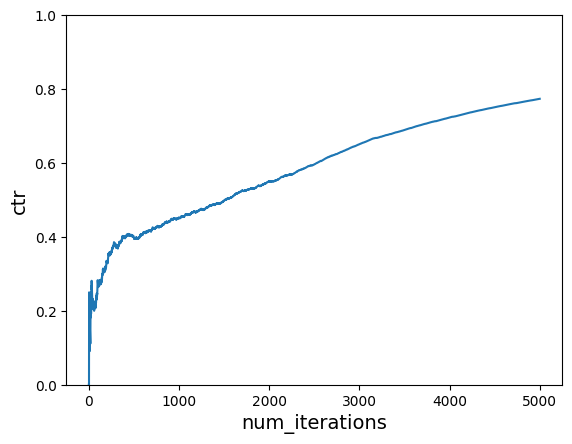

In [11]:
num_iterations = 5000
# Need to fit at least once.
model = MLPRegressor(activation="relu", random_state=42)
model.partial_fit([one_hot_encode("Tom", "morning", "politics")], [1])
ctr = run_simulation(model, num_iterations, users, times_of_day, actions, get_cost)
old_ctr = ctr
plot_ctr(num_iterations, ctr)

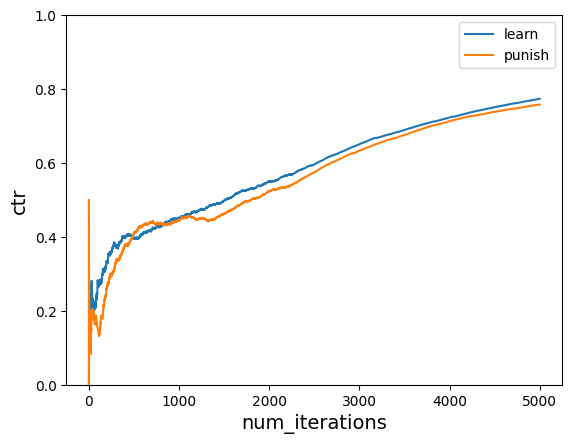

In [12]:
num_iterations = 5000
# Need to fit at least once.
model = MLPRegressor(activation="relu", random_state=42)
model.partial_fit([one_hot_encode("Tom", "morning", "politics")], [1])
ctr = run_simulation(
    model,
    num_iterations,
    users,
    times_of_day,
    actions,
    get_cost,
    do_learn=False,
    do_punish=True,
)

plt.plot(range(1, num_iterations + 1), old_ctr)
plot_ctr(num_iterations, ctr)
plt.legend(["learn", "punish"])

In [13]:
context = {"user": "Anna", "time_of_day": "morning"}
action, prob = get_action(model, context, actions)
action, prob

('camping', 0.04271871985718302)

In [14]:
context = {"user": "Anna", "time_of_day": "afternoon"}
action, prob = get_action(model, context, actions)
action, prob

('politics', 0.7823095941462722)

In [15]:
def get_cost_new1(context, action):
    match (context["user"], context["time_of_day"], action):
        case ("Tom", "morning", "politics"):
            return USER_LIKED_ARTICLE
        case ("Tom", "afternoon", "sports"):
            return USER_LIKED_ARTICLE
        case ("Anna", "morning", "sports"):
            return USER_LIKED_ARTICLE
        case ("Anna", "afternoon", "sports"):
            return USER_LIKED_ARTICLE
        case _:
            return USER_DISLIKED_ARTICLE

In [16]:
def run_simulation_multiple_cost_functions(
    model, num_iterations, users, times_of_day, actions, cost_functions, do_learn=True
):
    cost_sum = 0.0
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {"user": user, "time_of_day": time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(model, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                model.partial_fit([one_hot_encode(user, time_of_day, action)], [cost])

            ctr.append(1 * cost_sum / i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

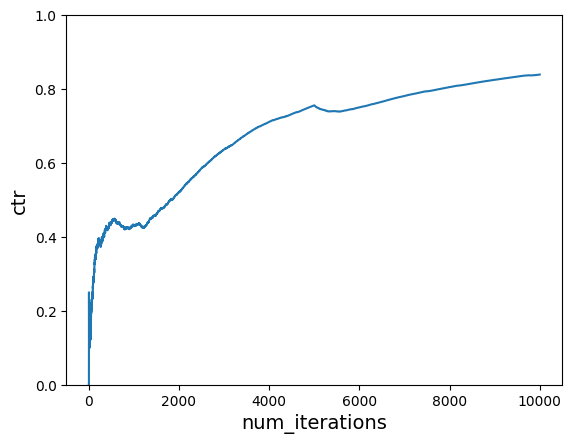

In [17]:
num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

model = MLPRegressor(activation="relu", random_state=42)
# Need to fit at least one data before using.
model.partial_fit([one_hot_encode("Tom", "morning", "politics")], [1])

ctr = run_simulation_multiple_cost_functions(
    model, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions
)

plot_ctr(total_iterations, ctr)